# How consistently are areas ranked?

For each month, compute the ranking of each area in terms of ASB incidents (with smoothing) and measure temporal consistency (somehow)


In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from typing import Literal

import matplotlib.pyplot as plt
import pandas as pd

from utils import (
    CATEGORIES,
    extract_crime_data,
    get_census_boundaries,
    get_force_boundary,
    lorenz_curve,
    tokenize_force_name,
)


In [38]:
FORCE = "West Yorkshire"
OBSERVATION_WINDOW = 3  # months
AREA: Literal["MSOA", "LSOA", "OA", "GRID", "HEX", "STREET"]
SAMPLE_FRACTION = 0.5

force_boundary = get_force_boundary(FORCE)

CATEGORY = CATEGORIES[1]
crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by catgegory and remove any points
crime_data = crime_data[crime_data["Crime type"] == CATEGORY]
crime_data = crime_data[crime_data.geometry.intersects(force_boundary.geometry.union_all())]
crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,geometry
Crime ID,,,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,NaN,NaN,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,NaN,NaN,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,NaN,NaN,POINT (446666.975 410800.005)


In [3]:
# get ALL the LSOAs in the force area
lsoa_boundaries = get_census_boundaries("LSOA21", "GC", overlapping=force_boundary)
lsoa_boundaries

,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
LSOA21CD,,,,,,,,
E01005409,Oldham 020D,None,402127,403557,53.5287,-1.96938,c07a6039-4c7e-4711-a4f1-43f133884e37,"POLYGON ((405025.033 406281.173, 405102.813 40..."
E01005410,Oldham 006A,None,402031,407499,53.5641,-1.97081,ec25b8b6-3bb2-41f4-9771-e203db1a4782,"POLYGON ((401277.5 409262.406, 401324.813 4092..."
E01005414,Oldham 006C,None,399091,410890,53.5946,-2.01521,decd0ebb-ac17-4239-bab5-0b04c1e50c3d,"POLYGON ((398471 413426.406, 398573.499 413253..."
E01005518,Rochdale 001A,None,394131,418913,53.6667,-2.09030,c0d478c0-aeba-45ea-83a4-cc9e1674772f,"POLYGON ((396713.094 420803.281, 396867.406 42..."
E01005521,Rochdale 003C,None,395569,416007,53.6406,-2.06849,f4ac1eb6-8200-4d86-af67-21981175e520,"POLYGON ((397738.5 417901.781, 397679.406 4176..."
...,...,...,...,...,...,...,...,...
E01035050,Leeds 105G,None,430214,426790,53.7366,-1.54345,4f0cba78-bfe1-4843-ab4b-bb44e691f99e,"POLYGON ((430737.415 427501.249, 430760.513 42..."
E01035051,Leeds 105H,None,431335,427174,53.7400,-1.52641,2de24ca1-ac16-44b0-a316-24ba49dba14c,"POLYGON ((431229.959 427511.255, 431264.502 42..."
E01035052,Leeds 105I,None,431014,426532,53.7343,-1.53135,1d808faa-55df-40ac-8dbd-50144f26e717,"POLYGON ((431312.508 427066, 431268.346 426814..."


In [9]:
# ensure we account for crime-free LSOAs in the data
counts = (
    crime_data.groupby(["Month", "LSOA code"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
)
counts = counts.reindex(lsoa_boundaries.index, fill_value=0)
num_areas = len(lsoa_boundaries)
# counts = counts.T
smoothed_counts = counts.T.rolling(OBSERVATION_WINDOW).mean().dropna().T
smoothed_counts

Month,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,...,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04
LSOA21CD,,,,,,,,,,,,,,,,,,,,,
E01005409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E01005410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E01005414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E01005518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E01005521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E01035050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.333333,1.666667,1.666667,1.666667,1.000000,0.666667,0.666667,0.666667,1.333333,1.666667
E01035051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
E01035052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.333333,0.333333,1.000000,1.000000,1.000000,0.333333,0.000000,0.666667,1.000000


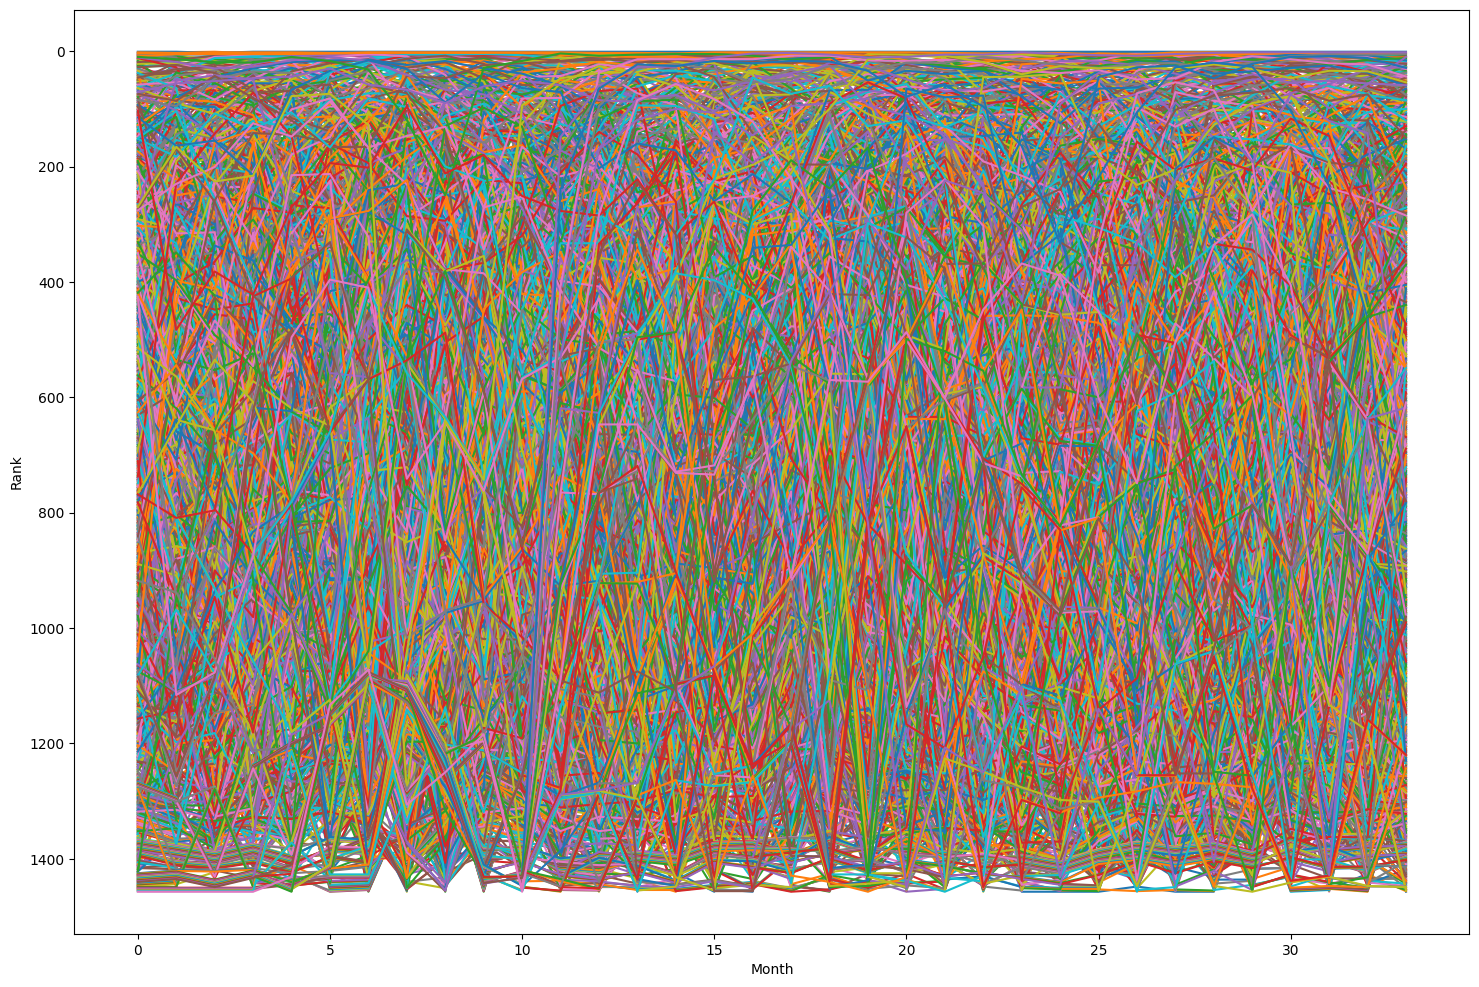

In [10]:
ranks = pd.concat(
    [
        pd.Series(
            index=smoothed_counts[col].sort_values(ascending=False).index, data=range(1, num_areas + 1)
        ).sort_index()
        for col in smoothed_counts.columns
    ],
    axis=1,
)
ax = ranks.T.plot(figsize=(18, 12), xlabel="Month", ylabel="Rank", legend=False)
ax.invert_yaxis()

# hmmm. Jackson Pollocks

In [ ]:
# # Top N for each period
# N = 15

# top_N = pd.concat(
#     [
#         pd.Series(smoothed_counts[col].sort_values(ascending=False).index[:N], name=col)
#         for col in smoothed_counts.columns
#     ],
#     axis=1,
# )
# top_N.index = pd.Index(top_N.index + 1, name="Rank")
# top_N

# persistent = (
#     pd.concat((top_N[col].value_counts() for col in top_N), axis=1).sum(axis=1).sort_values(ascending=False).to_frame()
# )
# persistent

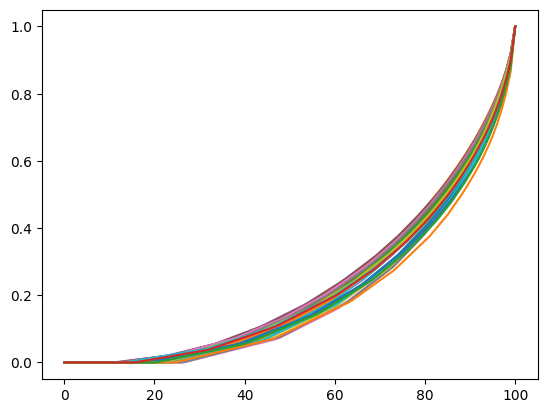

In [ ]:
def stats(counts: pd.Series):
    total_areas = len(counts)
    lorenz = lorenz_curve(counts, percentiles=True) #.sort_values().cumsum() / counts.sum()
    return pd.Series(
        data = {
            "prop_zero": (counts == 0).mean(),
            "prop_threshold": (lorenz >= SAMPLE_FRACTION).sum() / total_areas,
            "gini": "TODO",
            "lorenz": lorenz.to_numpy()
        },
        name = counts.name
    )


stats = pd.concat([stats(series) for _, series in smoothed_counts.items()], axis=1).T
stats


In [ ]:

fig, ax = plt.subplots()

for curve in stats.lorenz:
    ax.plot(range(101), curve)


In [8]:
# TODO look a Spearman rank correlation...